In [1]:
from tensorflow.keras.models import Model   
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from keras.saving import register_keras_serializable
import matplotlib.pyplot as plt
import cv2

In [2]:
import numpy as np

In [44]:
vgg= VGG16(include_top=False)

In [45]:
# vgg.summary()

In [ ]:
def model_build():
    input_layer=Input(shape=(120,120,3))
    vgg=VGG16(include_top=False)(input_layer)

    classif=GlobalMaxPooling2D()(vgg)
    class1=Dense(2000, activation='relu')(classif)
    class2=Dense(1, activation='sigmoid')(class1)

    regress=GlobalMaxPooling2D()(vgg)
    reg1=Dense(2000, activation='relu')(regress)
    reg2=Dense(4, activation='sigmoid')(reg1)

    featureEmb=GlobalMaxPooling2D()(vgg)
    feature1=Dense(512, activation='linear')(featureEmb)
    feature2=Dense(128, activation='linear')(feature1)

    faceDetector=Model(inputs=input_layer, outputs=[class2, reg2, feature2])
    return faceDetector

In [64]:
faceDetector=model_build()

In [65]:
faceDetector.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 2000)      │  1,026,000 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 2000)      │  1,026,000 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 512)       │    262,656 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1)         │      2,001 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 4)         │      8,004 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │     65,664 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,105,013 (65.25 MB)

 Trainable params: 2,390,325 (9.12 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
import tensorflow as tf

train=tf.data.Dataset.load('../saved_train')
val=tf.data.Dataset.load('../saved_val')
test=tf.data.Dataset.load('../saved_test')


In [67]:
X,y=train.as_numpy_iterator().next()

In [68]:
X.shape

(10, 120, 120, 3)

In [69]:
classes, coordinates, features=faceDetector.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


In [ ]:
# features

array([[ 1.2009916 ,  0.7834071 , -0.17085537, ..., -0.8294753 ,
         0.315015  ,  1.0839868 ],
       [ 0.80770427,  0.5569061 ,  0.7331507 , ..., -0.64190495,
        -0.07066849,  1.5909941 ],
       [ 1.3724303 ,  0.63251173,  0.63066816, ..., -1.8613449 ,
        -1.1161654 ,  1.1903627 ],
       ...,
       [ 0.99936426,  0.7829849 ,  1.267945  , ..., -1.6778128 ,
        -0.9151557 ,  1.0388683 ],
       [ 0.7701179 ,  0.38031787,  0.85536087, ..., -1.9374251 ,
         0.36758316,  0.7015667 ],
       [ 0.85121083,  0.3989312 ,  0.72651255, ..., -0.32751217,
        -0.25861394,  1.676516  ]], dtype=float32)

In [70]:
batches_per_epoch=len(train)
initial_learning_rate=0.0001
decay_steps=batches_per_epoch
decay_rate=0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # If True, decay happens at discrete intervals
)


In [71]:
opt=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [72]:
def compute_localization_loss(yTrue, yPred):
    coordinate=tf.reduce_sum(tf.square(yTrue[:,:2]-yPred[:,:2]))
    heightTrue=yTrue[:,3]-yTrue[:,1]
    widthTrue=yTrue[:,2]-yTrue[:,0]

    heightPred=yPred[:,3]-yPred[:,1]
    widthPred=yPred[:,2]-yPred[:,0]

    size=tf.reduce_sum(tf.square(widthTrue-widthPred) + tf.square(heightTrue-heightPred))

    return coordinate+size

In [74]:
classLoss=tf.keras.losses.BinaryCrossentropy()
regressLoss=compute_localization_loss
featureLoss=tf.keras.losses.MeanSquaredError()

In [17]:
# compute_localization_loss(y[1], coordinates)
# classLoss(y[0],classes)

In [75]:
print("Shape of X:", X.shape)  # Should print (batch_size, 120, 120, 3)
print("Shape of y[0] (class labels):", y[0].shape)  # Should print (batch_size, num_classes)
print("Shape of y[1] (bounding boxes):", y[1].shape)  # Should print (batch_size, num_boxes, 4)

Shape of X: (10, 120, 120, 3)
Shape of y[0] (class labels): (10, 1)
Shape of y[1] (bounding boxes): (10, 4)


In [ ]:
@register_keras_serializable()
class FaceDetector(Model):
    def __init__(self, faceDetector, **kwargs):
        super().__init__(**kwargs)
        self.model=faceDetector

    def compile(self, opt, classLoss, regressLoss, featureLoss, **kwargs):
            # super().compile(**kwargs)
            # self.opt=opt
            # self.cLoss=classLoss
            # self.lLoss=regressLoss

            super().compile(
                  optimizer=opt,
                  loss=[classLoss,regressLoss,featureLoss],
                  **kwargs
            )
            self.opt=opt
            self.cLoss=classLoss
            self.lLoss=regressLoss
            self.fLoss=featureLoss

            # self.cLoss=loss.get('classification')
            # self.lLoss=loss.get('regression')
            # super().compile(optimizer=opt, loss={'classification': self.cLoss, 'regression': self.lLoss},**kwargs)
            # self.opt=opt

    def train_step(self, batch, **kwargs):
        X,y=batch
        # Ensure the shape of X is (batch_size, 120, 120, 3)
        X = tf.ensure_shape(X, [None, 120, 120, 3])

        y = list(y)

        # # Ensure y has the expected shape (batch_size, num_classes) for class labels
        y[0] = tf.ensure_shape(y[0], [None, 1])  # Adjust num_classes as needed
        y[1] = tf.ensure_shape(y[1], [None, 4])  # Adjust num_boxes as needed

        y = tuple(y)


        # print(f"Rank of X: {tf.rank(X)}")
        # print(f"Rank of y: {tf.rank(y)}")
        with tf.GradientTape()  as tape:
              classes,coordinates,features= self.model(X,training=True)
              classLoss=self.cLoss(y[0],classes)
              localizationLoss=self.lLoss(tf.cast(y[1],tf.float32),coordinates)
            #   featureLoss=self.fLoss(1,features)
              totalLoss=0.5*classLoss+localizationLoss
              grad=tape.gradient(totalLoss,self.model.trainable_variables)

        opt.apply_gradients(zip(grad,self.model.trainable_variables))   
        return {'totalLoss':totalLoss, 'classLoss':classLoss, 'regressLoss':localizationLoss
                # , 'featureLoss':featureLoss
                }

    def test_step(self, batch, **knwargs):
              
            X,y=batch

            # Ensure the shape of X is (batch_size, 120, 120, 3)
            X = tf.ensure_shape(X, [None, 120, 120, 3])

            y = list(y)

            # # Ensure y has the expected shape (batch_size, num_classes) for class labels
            y[0] = tf.ensure_shape(y[0], [None, 1])  # Adjust num_classes as needed
            y[1] = tf.ensure_shape(y[1], [None, 4])  # Adjust num_boxes as needed

            y = tuple(y)

            classes,coordinates= self.model(X,training=True)
            classLoss=self.cLoss(y[0],classes)
            localizationLoss=self.lLoss(tf.cast(y[1],tf.float32),coordinates)
            #   featureLoss=self.fLoss(1,features)
            totalLoss=0.5*classLoss+localizationLoss

            return {'totalLoss':totalLoss, 'classLoss':classLoss, 'regressLoss':localizationLoss 
                    # , 'featureLoss':featureLoss
                    }
    
    def call(self, X, **kwargs):
          return self.model(X, **kwargs)
    
    def get_config(self):
        config = super().get_config()
        config.update({"faceDetector": self.model.to_json()})  
        return config

    @classmethod
    def from_config(cls, config):
        from tensorflow.keras.models import model_from_json
        faceDetector = config.pop("faceDetector") 
        faceDetector = model_from_json(faceDetector)
        return cls(faceDetector, **config)
            



In [20]:
model=FaceDetector(faceDetector)

In [21]:
# print(model)

In [ ]:
# model.compile(opt, classLoss, regressLoss, featureLoss)
model.compile(opt, classLoss, regressLoss)
# model.compile(opt, loss={'classification': classLoss, 'regression': regressLoss})

In [23]:
logDir='../visulaizationData'

In [24]:
tensorBoard=tf.keras.callbacks.TensorBoard(log_dir=logDir)

In [26]:
hist=model.fit(train, epochs=10, validation_data=val, callbacks=[tensorBoard])

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - classLoss: 0.0649 - regressLoss: 0.3197 - totalLoss: 0.3522 - val_classLoss: 0.0020 - val_regressLoss: 0.0489 - val_totalLoss: 0.0499
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - classLoss: 0.0567 - regressLoss: 0.2383 - totalLoss: 0.2666 - val_classLoss: 0.0016 - val_regressLoss: 0.0521 - val_totalLoss: 0.0529
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - classLoss: 0.0287 - regressLoss: 0.1541 - totalLoss: 0.1684 - val_classLoss: 0.0016 - val_regressLoss: 0.0361 - val_totalLoss: 0.0369
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - classLoss: 0.0177 - regressLoss: 0.1056 - totalLoss: 0.1145 - val_classLoss: 0.0026 - val_regressLoss: 0.0375 - val_totalLoss: 0.0387
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - classLoss: 0.0112 - regressLoss: 0.1010 - totalLoss: 0.1066 - val_classLoss: 4.1144e-04 - val_regressLoss: 0.0311 - val_totalLoss: 0.0313
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - classLoss: 0.

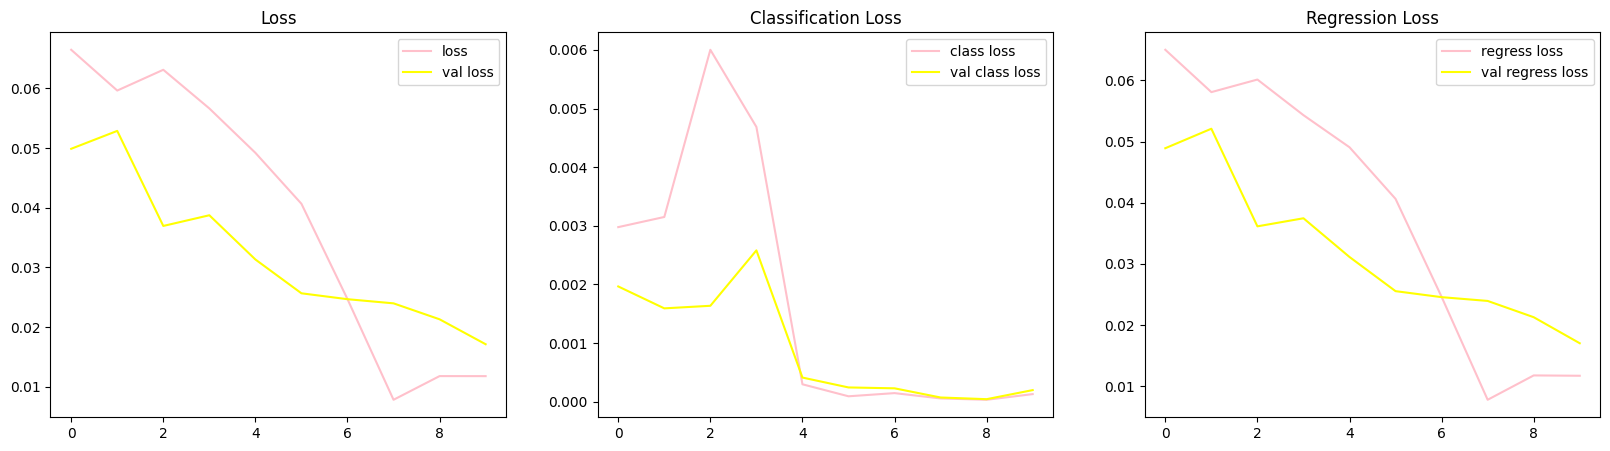

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['totalLoss'], color='pink', label='loss')
ax[0].plot(hist.history['val_totalLoss'], color='yellow', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['classLoss'], color='pink', label='class loss')
ax[1].plot(hist.history['val_classLoss'], color='yellow', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regressLoss'], color='pink', label='regress loss')
ax[2].plot(hist.history['val_regressLoss'], color='yellow', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
# Now here model is saved 

In [ ]:
model.save("../Model/modelFaceDetection.keras")
# model.save("../Model/modelfeatureEmbedding.keras")

In [33]:
from tensorflow import keras
model = keras.models.load_model("../Model/modelFaceDetection.keras", custom_objects={"FaceDetector": FaceDetector}, compile=False)

In [34]:
print(hasattr(model, "optimizer"))

False


In [76]:
model.summary()

Model: "face_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ ((None, 1), (None, 4)) │    16,776,693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,776,693 (64.00 MB)

 Trainable params: 16,776,693 (64.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# retraining

In [79]:
model.compile(opt, classLoss, regressLoss)

In [87]:
history=model.fit(train,epochs=10,validation_data=val)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - classLoss: 0.0102 - regressLoss: 0.1257 - totalLoss: 0.1308 - val_classLoss: 1.9033e-04 - val_regressLoss: 0.0969 - val_totalLoss: 0.0970
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - classLoss: 0.0014 - regressLoss: 0.0494 - totalLoss: 0.0501 - val_classLoss: 3.9731e-05 - val_regressLoss: 0.0326 - val_totalLoss: 0.0326
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - classLoss: 1.1230e-04 - regressLoss: 0.0236 - totalLoss: 0.0237 - val_classLoss: 2.1228e-05 - val_regressLoss: 0.0287 - val_totalLoss: 0.0287
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - classLoss: 0.0106 - regressLoss: 0.0361 - totalLoss: 0.0414 - val_classLoss: 1.7728e-05 - val_regressLoss: 0.0244 - val_totalLoss: 0.0244
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - classLoss: 0.0019 - regressLoss: 0.0403 - totalLoss: 0.0412 - val_classLoss: 2.6824e-05 - val_regressLoss: 0.1040 - val_totalLoss: 0.1041
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/s

In [89]:
history.history

{'classLoss': [0.0003103438066318631,
  2.5975776225095615e-05,
  2.1793977794004604e-05,
  1.5204243936750572e-05,
  3.4369972127024084e-05,
  0.01300822664052248,
  0.00035023604868911207,
  7.398931484203786e-05,
  6.802620919188485e-05,
  1.496950631008076e-06],
 'regressLoss': [0.06080377846956253,
  0.05567397549748421,
  0.01712261512875557,
  0.009350099600851536,
  0.06597661972045898,
  0.0737207680940628,
  0.02419952303171158,
  0.00537919532507658,
  0.009034913033246994,
  0.012409853748977184],
 'totalLoss': [0.06095895171165466,
  0.055686961859464645,
  0.01713351160287857,
  0.009357701987028122,
  0.06599380820989609,
  0.08022487908601761,
  0.024374641478061676,
  0.005416189786046743,
  0.009068925864994526,
  0.012410602532327175],
 'val_classLoss': [0.00019032687123399228,
  3.973070488427766e-05,
  2.1228159312158823e-05,
  1.772838550095912e-05,
  2.6824422093341127e-05,
  0.0026973742060363293,
  0.0005679421592503786,
  8.749681001063436e-05,
  0.00014661633

In [88]:
model.save("../Model/modelFaceDetection.keras")

In [ ]:
# model = keras.models.load_model("../Model/modelFaceDetection.keras", custom_objects={"FaceDetector": FaceDetector}, compile=False)

In [37]:
testData=test.as_numpy_iterator()

In [38]:
testSample=testData.next()

In [39]:
yPred=faceDetector.predict(testSample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


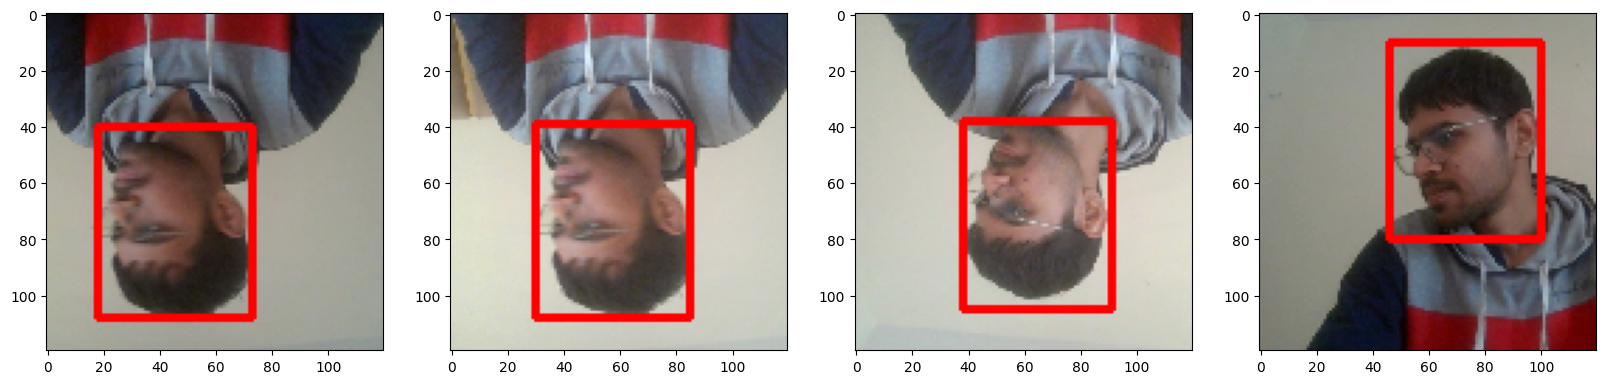

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = testSample[0][idx]
    sample_coords = yPred[1][idx]

    sample_image = sample_image.copy()
    
    if yPred[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
# cap=cv2.VideoCapture(0)

# while cap.isOpened():
#     _,frame=cap.read()
#     frame = frame[50:500, 50:500,:]
#     rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     resized = tf.image.resize(rgb, (120,120))
#     yPred=model.predict(np.expand_dims(resized/255,0))
#     coords=yPred[1][0]
    
#     if yPred[0]>0.5:
#         cv2.rectangle(frame, tuple(np.multiply(coords[:2], [450,450]).astype(int)), tuple(np.multiply(coords[2:], [450,450]).astype(int)), (255,200,0), 2)

#         cv2.rectangle(frame, 
#                       tuple(np.add(np.multiply(coords[:2], [450,450]).astype(int), 
#                                     [0,-30])),
#                       tuple(np.add(np.multiply(coords[:2], [450,450]).astype(int),
#                                     [80,0])), 
#                             (255,0,0), -1)
        
#         cv2.putText(frame, 'face', tuple(np.add(np.multiply(coords[:2], [450,450]).astype(int),
#                                                [0,-5])),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

#     cv2.imshow('Face Track', frame)

#     if cv2.waitKey(1) & 0xFF == ord('b'):
#         break

# cap.release()
# cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━